# Model Building:

## Collaborative Filtering (Item-Item) using Singular Value Decomposition (SVD):

### Import necessary libraries

In [1]:
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split

INTERIM_DATA_DIR = "../data/interim/"

### Load the dataset

In [2]:
ratings_df = pd.read_csv(f"{INTERIM_DATA_DIR}ratings.csv")
users_df = pd.read_csv(f"{INTERIM_DATA_DIR}users.csv")
movies_info_df = pd.read_csv(f"{INTERIM_DATA_DIR}movies_info.csv")
merged_data = pd.read_csv(f"{INTERIM_DATA_DIR}merged.csv")

### Create a user-item matrix

In [4]:
# Create a user-item matrix
user_item_matrix = merged_data.pivot_table(index='user_id', columns='movie_id', values='rating')
user_item_matrix.fillna(0, inplace=True)

# Convert the user-item matrix to a sparse matrix format
sparse_user_item_matrix = csr_matrix(user_item_matrix.values)


### Training:

In [5]:
from sklearn.decomposition import TruncatedSVD

# Define the SVD model
n_components = 300  # Number of latent factors
model = TruncatedSVD(n_components=n_components, random_state=42)

# Split data into training and testing sets
train_data, test_data = train_test_split(sparse_user_item_matrix, test_size=0.2, random_state=42)

# Fit the model on the training data
model.fit(train_data)


TruncatedSVD(n_components=300, random_state=42)

### Running Predictions:

In [6]:
def recommend_movies(user_id, model, user_item_matrix, n_recommendations=5):
    # Check if user_id exists in the matrix
    if user_id not in user_item_matrix.index:
        return "User not found in the dataset"
    
    # Reconstruct the user-item matrix
    reconstructed_matrix = model.transform(user_item_matrix) @ model.components_
    
    # Convert the reconstructed matrix back to a DataFrame
    reconstructed_df = pd.DataFrame(reconstructed_matrix, index=user_item_matrix.index, columns=user_item_matrix.columns)
    
    # Get the user's predictions
    user_predictions = reconstructed_df.loc[user_id].sort_values(ascending=False)
    
    # Filter out movies the user has already rated
    known_ratings = user_item_matrix.loc[user_id]
    user_predictions = user_predictions[known_ratings.isna() | (known_ratings == 0)]
    
    user_predictions = pd.DataFrame({'movie_id': user_predictions.index, 'predicted_rating': user_predictions.values}, index=None)
    user_predictions['predicted_rating'] = user_predictions['predicted_rating'] * 4 + 1
    user_predictions = user_predictions.round(2)
    # Merge with the movie titles using the 'movie_id'
    user_predictions = user_predictions.merge(movies_info_df[['movie_id', 'movie_name']], on='movie_id', how='left')
    
    # Return the top n recommendations
    return user_predictions.head((n_recommendations))

In [7]:
user_id = 2
recommended_movies = recommend_movies(user_id, model, user_item_matrix)
print(recommended_movies)

   movie_id  predicted_rating            movie_name
0       713              1.61               Othello
1       896              1.60  Sweet Hereafter, The
2      1012              1.60         Private Parts
3       750              1.56               Amistad
4       740              1.56             Jane Eyre


In [8]:
import numpy as np

def make_predictions(test_data):
    # Transform the test data using the trained model
    test_user_features = model.transform(test_data)

    # Reconstruct the predictions for the test set
    test_predictions = test_user_features @ model.components_

    # Flatten the test set predictions to compute RMSE and MAE
    # Only select the non-zero entries from the original test set
    y_pred = test_predictions[test_data.nonzero()].flatten()  # Predicted ratings
    
    return y_pred


## Evaluation:

### Running (RMSE, MAE) evaluations on the test set:

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate(test_data):
    y_pred = make_predictions(test_data) # Predicted ratings
    y_true = test_data.data  # Actual ratings

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    # Calculate MAE
    mae = mean_absolute_error(y_true, y_pred)
    
    # print(f'Root Mean Squared Error: {rmse:0.4}')
    # print(f'Mean Absolute Error: {mae:0.4}')
    
    return rmse, mae
    

- Root Mean Squared Error (RMSE) of 0.3337: This value is relatively low, which suggests that the model's predictions are close to the actual ratings on average. RMSE gives a relatively high weight to large errors, so a low RMSE value indicates that there are not many large errors in the predictions, which is good.

- Mean Absolute Error (MAE) of 0.2797: This value is also quite low and complements the RMSE. MAE provides a straightforward interpretation of the average magnitude of errors. A MAE of approximately 0.28 means that, on average, the model's predicted ratings are about 0.28 points different from the actual ratings. Given that the MovieLens dataset ratings are on a scale from 1 to 5, this is a small error, indicating good predictive performance.

In [10]:
rmses, maes = [], []

components = range(50,1001,50)

for n_components in components:    
    model = TruncatedSVD(n_components=n_components, random_state=42)
    model.fit(train_data)
    rmse, mae = evaluate(test_data)
    rmses.append(rmse)
    maes.append(mae)

### Plot:

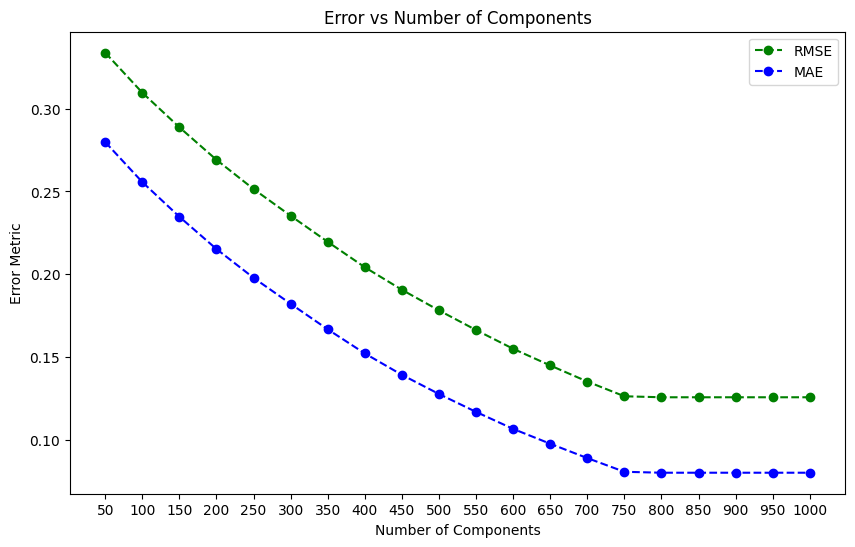

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(components, rmses, 'go--', label = "RMSE")
plt.plot(components, maes, 'bo--', label = "MAE")
plt.xticks(components)
# plt.yticks(list(set(rmses).union(maes)))
plt.xlabel('Number of Components')  
plt.ylabel('Error Metric')

# displaying the title 
plt.title(label="Error vs Number of Components")
plt.legend() 
plt.show()

In [12]:
model = model = TruncatedSVD(n_components=750, random_state=42)
model.fit(train_data)

TruncatedSVD(n_components=750, random_state=42)

In [15]:
user_id = int(input("Enter the id of the user you want to recommend movies to: "))
recommended_movies = recommend_movies(user_id, model, user_item_matrix)
print(recommended_movies)

   movie_id  predicted_rating           movie_name
0       936              1.65          Brassed Off
1      1388              1.57               Gabbeh
2       296              1.49         Promesse, La
3       952              1.42     Blue in the Face
4       979              1.40  Trigger Effect, The
